<a href="https://colab.research.google.com/github/AmirRazaMBA/Tensorflow-in-Practice-Specialization/blob/main/3.%20Natural%20Language%20Processing%20in%20TensorFlow/Codes/Exam%20Prep/Tokenization_Embedding/05_nlp_subwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's in a (sub)word?

In this colab, we'll work with subwords, or words made up of the pieces of larger words, and see how that impacts our network and related embeddings.

We’ve worked with full words before for our sentiment models, and Jocelyn had shown us some issues right at the start of the lesson when using character-based tokenization. Subwords are another approach, where individual words are broken up into the more commonly appearing pieces of themselves. This helps avoid marking very rare words as OOV when you use only the most common words in a corpus.

As shown in the video, this can further expose an issue affecting all of our models up to this point, in that they don’t understand the full context of the sequence of words in an input. The next lesson on recurrent neural networks will help address this issue.

https://video.udacity-data.com/topher/2020/March/5e6fb669_subwords/subwords.png

Subword Datasets

There are a number of already created subwords datasets available online. If you check out the IMDB dataset on TFDS https://www.tensorflow.org/datasets/catalog/imdb_reviews, for instance, by scrolling down you can see datasets with both 8,000 subwords as well as 32,000 subwords in a corpus (along with regular full-word datasets).

However, I want you to know how to create these yourself as well, so we’ll use TensorFlow’s SubwordTextEncoder and its build_from_corpus function to create one from the reviews dataset we used previously.


## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

## Get the original dataset

We'll once again use the dataset containing Amazon and Yelp reviews. This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2020-10-31 17:49:44--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.20.102, 74.125.20.138, 74.125.20.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rggksm1q3ivnmkbhm5om65sujntnrro3/1604166525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-10-31 17:49:45--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rggksm1q3ivnmkbhm5om65sujntnrro3/1604166525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.125.142

In [3]:
path = tf.keras.utils.get_file('sentiment.csv', 'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')

131072/127831 [==============================] - 0s 0us/step


In [5]:
import pandas as pd

#dataset = pd.read_csv('/tmp/sentiment.csv')
dataset = pd.read_csv(path)

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

## Create a subwords dataset

We can use the existing Amazon and Yelp reviews dataset with `tensorflow_datasets`'s `SubwordTextEncoder` functionality. `SubwordTextEncoder.build_from_corpus()` will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword `vocab_size` of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

Check out the related documentation [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus).

In [6]:
import tensorflow_datasets as tfds

In [7]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [9]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [11]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Replace sentence data with encoded subwords

Now, we'll re-create the dataset to be used for training by actually encoding each of the individual sentences. This is equivalent to `text_to_sequences` with the `Tokenizer` we used in earlier exercises.

In [12]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [13]:
# Check the sentences are appropriately replaced
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


## Final pre-processing

Before training, we still need to pad the sequences, as well as split into training and test sets.

In [14]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Train a Sentiment Model

In [15]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5330 - val_loss: 0.6928 - val_accuracy: 0.5013
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.6999 - val_loss: 0.6902 - val_accuracy: 0.7018
Epoch 3/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.7602 - val_loss: 0.6844 - val_accuracy: 0.6516
Epoch 4/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6715 - accuracy: 0.7445 - val_loss: 0.6711 - val_accuracy: 0.7018
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6507 - accuracy: 0.7659 - val_loss: 0.6554 - val_accuracy: 0.6992
Epoch 6/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6204 - accuracy: 0.7928 - val_loss: 0.6315 - val_accuracy: 0.7393
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.5847 - accuracy: 0.8085 - val_loss: 0.6024 - val_accuracy: 0.7669
Epoch 8/30
50/50 [==

## Visualize the Training Graph

We can visualize the training graph below again. Does there appear to be a difference in how validation accuracy and loss is trending compared to with full words?

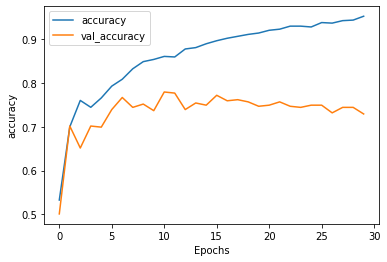

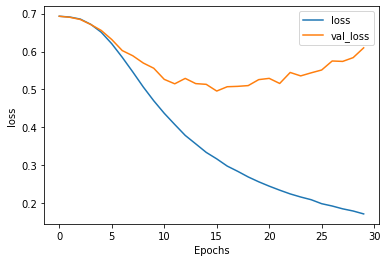

In [17]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Get files for visualizing the network

Once again, you can visualize the sentiment related to all of the subwords using the below code and by heading to http://projector.tensorflow.org/ to upload and view the data.

Note that the below code does have a few small changes to handle the different way text is encoded in our dataset compared to before with the built in `Tokenizer`.

You may get an error like "Number of tensors (999) do not match the number of lines in metadata (992)." As long as you load the vectors first without error and wait a few seconds after this pops up, you will be able to click outside the file load menu and still view the visualization.

In [18]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [19]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [20]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You’ve already learned an amazing amount of material on Natural Language Processing with TensorFlow in this lesson.

You started with Tokenization by:

    Tokenizing input text
    Creating and padding sequences
    Incorporating out of vocabulary words
    Generalizing tokenization and sequence methods to real world datasets

From there, you moved onto Embeddings, where you:

    transformed tokenized sequences into embeddings
    developed a basic sentiment analysis model
    visualized the embeddings vector
    tweaked hyperparameters of the model to improve it
    and diagnosed potential issues with using pre-trained subword tokenizers when the network doesn’t have sequence context

In the next lesson, you’ll dive into Recurrent Neural Networks, which will be able to understand the sequence of inputs, and you'll learn how to generate new text.
